<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/09_SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (we're using data from) is here https://arxiv.org/abs/1710.06071

and here: https://arxiv.org/abs/1612.05251

## Confirm access to GPU

In [97]:
!nvidia-smi

Fri Nov 10 21:03:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   2323MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

The data is available at the author's GitHub!!!: https://github.com/Franck-Dernoncourt/pubmed-rct

In [98]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [99]:
# Check what files are in the PubMed_20K dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
# dev is often just another word for validation dataset

dev.txt  test.txt  train.txt


In [100]:
# Start our experiments using the 20k dataset with numbers replaced with the @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [101]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data
https://realpython.com/read-write-files-python/

In [102]:
# Create fcn to read lines of the document
def get_lines(filename):
  """
  Reads a txt file (filename) and returns a list of the lines
  """
  with open(filename, "r") as f:
    return f.readlines()

In [103]:
# Let's read in the training lines
train_lines = get_lines(filenames[0])
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [104]:
len(train_lines)

210040

How do we want our data to look, to be best represented

List of dictionaries:

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'
   'total_lines': 11},
   another line dictionary]
```

In [105]:
test_lines = get_lines(filenames[1])
val_lines = get_lines(filenames[2])

In [106]:
# write a function to turn our lines into dictionaries
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract text data.
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an abstract ID
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # line is split into label and content
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower()  # get target text and lower it
        line_data["line_number"] = abstract_line_number # at what number does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split)-1 # how many lines there are in the total abstract
        abstract_samples.append(line_data)

    else: # the line contains the label sentence
      abstract_lines += line

  return abstract_samples

In [107]:
# Get the data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[2])
test_samples = preprocess_text_with_line_numbers(filenames[1])
train_samples[:10]

CPU times: user 742 ms, sys: 86.3 ms, total: 828 ms
Wall time: 1.8 s


[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [108]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df[:15]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [109]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

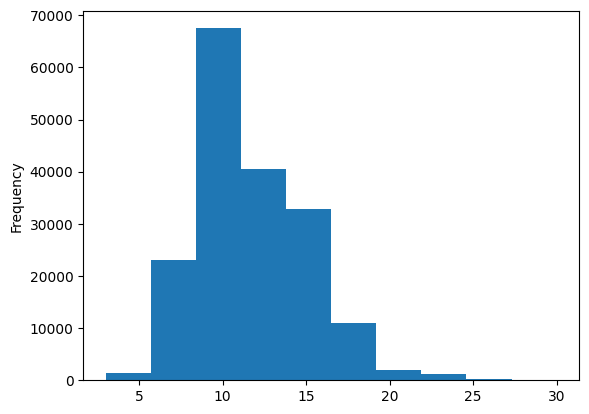

In [110]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences


In [111]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models require numerical labels)

In [112]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [113]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy()) # fits the encoder and encodes at once
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [114]:
# Get classnames and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline - TF-IDF Multinomial Naive Bayes

https://monkeylearn.com/blog/what-is-tf-idf/

https://chrisalbon.com/Home

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipoeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [116]:
# Evaluate baseline model on the validation dataset
model_0.score(X=val_sentences, # equivalent to keras .evaluate()
              y=val_labels_encoded)

0.7218323844829869

In [117]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper functions script

In [118]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2023-11-10 21:03:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-10 21:03:49 (87.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [119]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the text - turn it into numeric format - tokenization and embedding

In [120]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [121]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

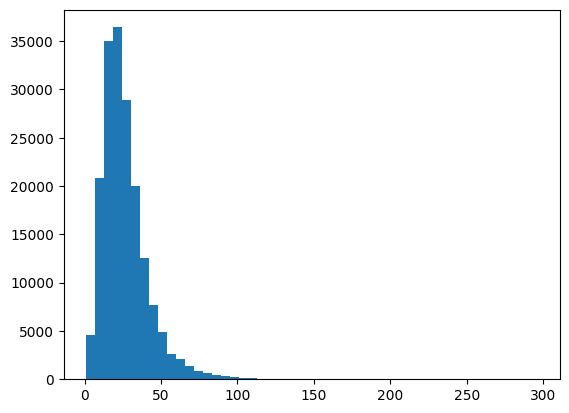

In [122]:
# What's the distribution like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=50);

Let's find out in what length 95% of the data can be contained

https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

In [123]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len
# We'll be padding and truncating sentences to that length

55

In [124]:
# Maximum sequence length in the training data (just out of curiosity)
max(sent_lens)

296

### Creating a text vectorizer layer

That layer will map our words to numbers

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [125]:
# How many words are in our vocabulary? (taken from Table 2)
max_tokens = 68000

In [126]:
# Create text tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # number of words in a sentence

In [127]:
# Adapt text tokenizer to the training data
text_vectorizer.adapt(train_sentences)

In [128]:
# Test out text tokenizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n\nLength:{len(target_sentence.split())}\n\nTokenized version: {text_vectorizer(target_sentence)}")

Text:
ts may help lower pain in children post tonsillectomy and decrease demand for iv opioid pain management in the @ - to @-year-old tonsillectomy population .

Length:26

Tokenized version: [3832   91  909  105   65    5  109  624 5044    3  318 3825   11  651
 1080   65  287    5    2    6 4004 5044  278    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [129]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}\nMost common words in the vocab: {rct_20k_text_vocab[2:7]}")

Number of words in vocab: 64841
Most common words in the vocab: ['the', 'and', 'of', 'in', 'to']


In [130]:
# Get the config of the text tokenizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create an embedding

In [131]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # more captures more info, less learns faster
                               mask_zero=True, # use masking to handle variable sequence lengths - doesnt compute zero values unnecessarily
                               name="token_embedding")

In [132]:
# Show an example of embedding
print(f"Sentence before tokenization: {target_sentence}\n")
print(f"Sentence after tokenization: {text_vectorizer(target_sentence)}\n")
print(f"Sentence after embedding: {token_embed(text_vectorizer(target_sentence))}")
vectorized_sentence = text_vectorizer(target_sentence)
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before tokenization: ts may help lower pain in children post tonsillectomy and decrease demand for iv opioid pain management in the @ - to @-year-old tonsillectomy population .

Sentence after tokenization: [3832   91  909  105   65    5  109  624 5044    3  318 3825   11  651
 1080   65  287    5    2    6 4004 5044  278    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]

Sentence after embedding: [[-0.0326699   0.02117546 -0.02399037 ...  0.03535015  0.03766927
  -0.04916003]
 [-0.01200124  0.02744354 -0.02294976 ...  0.0106458   0.03556384
  -0.04017808]
 [ 0.04583475  0.02508796  0.04951509 ... -0.03593606 -0.03688354
  -0.01084514]
 ...
 [ 0.00964487  0.03751487  0.04335238 ...  0.03767056 -0.00052672
   0.01715786]
 [ 0.00964487  0.03751487  0.04335238 ...  0.03767056 -0.00052672
   0.01715786]
 [ 0.00964487  0.03751487  0.04335238 ...  0.03767056 -0.00052672
 

## Turning data into prefetch datasets to increase speed of loading

https://www.tensorflow.org/guide/data_performance?hl=pl

https://www.tensorflow.org/api_docs/python/tf/data

In [133]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [134]:
# Take the tensor slice datasets and turn them into prefetch datasets and into batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [135]:
# Build the model the functional way
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_tokens = text_vectorizer(inputs)
token_embeddings = token_embed(text_tokens)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(optimizer="Adam",
                loss="categorical_crossentropy",
                metrics="accuracy")

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_4  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                           

In [136]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)), # no need for this as the model trains fast anyway
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 30s 51ms/step - loss: 0.9199 - accuracy: 0.6358 - val_loss: 0.6885 - val_accuracy: 0.7370
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 0.6585 - accuracy: 0.7565 - val_loss: 0.6371 - val_accuracy: 0.7676
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.6190 - accuracy: 0.7730 - val_loss: 0.5999 - val_accuracy: 0.7856
Epoch 4/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5898 - accuracy: 0.7890 - val_loss: 0.5833 - val_accuracy: 0.7836
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.5936 - accuracy: 0.7910 - val_loss: 0.5638 - val_accuracy: 0.7982


In [137]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5624 - accuracy: 0.8006


[0.5623673796653748, 0.8005759119987488]

In [138]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[5.3656673e-01, 1.5474501e-01, 3.6056403e-02, 2.0947224e-01,
        6.3159555e-02],
       [4.5131275e-01, 3.4451467e-01, 2.5610961e-02, 1.4059021e-01,
        3.7971396e-02],
       [1.8249543e-01, 4.3257601e-03, 2.2359029e-03, 8.1089985e-01,
        4.3140019e-05],
       ...,
       [3.7441241e-05, 6.1299279e-04, 3.3712629e-03, 3.2021646e-05,
        9.9594635e-01],
       [9.5364399e-02, 2.6663309e-01, 1.2514189e-01, 6.6647545e-02,
        4.4621310e-01],
       [1.3953276e-01, 7.8074294e-01, 3.8829755e-02, 1.7151758e-02,
        2.3742788e-02]], dtype=float32)

In [139]:
# Convert to classes
model_1_preds = tf.argmax(tf.squeeze(model_1_pred_probs), axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [140]:
# Calculate model 1 results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 80.05759300940024,
 'precision': 0.7997642491892488,
 'recall': 0.8005759300940024,
 'f1': 0.7976484432696256}

## MOdel 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from Tensorflow Hub:

https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings. We're going to use the USE

In [141]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [142]:
# Test out pretrained embedding
random_train_sentence = random.choice(train_sentences)
print(f"Original sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Embedded sentence:\n{use_embedded_sentence}")
print(f"Length of the sentence embedding:\n{len(tf.squeeze(use_embedded_sentence))}")

Original sentence:
the most common gastrointestinal adverse events were nausea ( @ -lsb- @ % -rsb- in dulaglutide group vs @ -lsb- @ % -rsb- in liraglutide group ) , diarrhoea ( @ -lsb- @ % -rsb- vs @ -lsb- @ % -rsb- ) , dyspepsia ( @ -lsb- @ % -rsb- vs @ -lsb- @ % -rsb- ) , and vomiting ( @ -lsb- @ % -rsb- vs @ -lsb- @ % -rsb- ) , with similar rates of study or study drug discontinuation because of adverse events between the two groups ( @ -lsb- @ % -rsb- in each group ) .
Embedded sentence:
[[-0.0432265  -0.05638833 -0.05437373 -0.0384931   0.06303348 -0.06451729
  -0.04839337 -0.00465028  0.02032973  0.06124443  0.06410398 -0.0651573
   0.05879032  0.03502628 -0.04727603  0.01212802 -0.06456649 -0.06604203
   0.00590218  0.01940064  0.06569377  0.02260531 -0.04648384 -0.03778502
  -0.00223841  0.04021192  0.02500685  0.00957673 -0.05401192 -0.00629271
   0.06316081  0.05772328 -0.05203459  0.00536259 -0.04475718  0.05715322
   0.0418332  -0.03901511 -0.02446084 -0.0048377   0.051347

### Building and fitting model 2

In [143]:
# Define feature extraction model using the input layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding) # could be more
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extraction")

# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [144]:
model_2.summary()

Model: "model_2_USE_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [145]:
# Fit model 2
history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_dataset)), # no need for this as the model trains fast anyway
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 11s 15ms/step - loss: 0.9198 - accuracy: 0.6499 - val_loss: 0.7965 - val_accuracy: 0.6878
Epoch 2/5
562/562 [==============================] - 11s 20ms/step - loss: 0.7686 - accuracy: 0.7013 - val_loss: 0.7534 - val_accuracy: 0.7031
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7516 - accuracy: 0.7115 - val_loss: 0.7371 - val_accuracy: 0.7144
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7168 - accuracy: 0.7245 - val_loss: 0.7072 - val_accuracy: 0.7320
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7245 - accuracy: 0.7211 - val_loss: 0.6858 - val_accuracy: 0.7394


In [146]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 14ms/step - loss: 0.6953 - accuracy: 0.7365


[0.6953389644622803, 0.7365285158157349]

In [147]:
# Make predictions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs

945/945 [==============================] - 11s 12ms/step


array([[6.1982924e-01, 2.4976023e-01, 2.6918158e-03, 1.1815996e-01,
        9.5587503e-03],
       [4.5497751e-01, 4.4725090e-01, 5.2424506e-03, 9.0377949e-02,
        2.1511791e-03],
       [3.6750236e-01, 7.8093767e-02, 3.6831293e-02, 4.6237674e-01,
        5.5195820e-02],
       ...,
       [2.1304565e-03, 1.8828253e-03, 7.5546801e-02, 5.4023543e-04,
        9.1989964e-01],
       [2.7475194e-03, 2.2697499e-02, 5.1394194e-01, 9.4118563e-04,
        4.5967183e-01],
       [1.8775955e-01, 3.7174085e-01, 3.9401996e-01, 2.5288514e-03,
        4.3950789e-02]], dtype=float32)

In [148]:
# Convert to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 2])>

In [149]:
# Calculate results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 73.65285317092545,
 'precision': 0.7328879030509533,
 'recall': 0.7365285317092546,
 'f1': 0.7307037814248555}

## Model 3: Conv1D with character level embedding

### Create a character-level tokenizer

In [150]:
# Make function to split sentence into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   m o s t   c o m m o n   g a s t r o i n t e s t i n a l   a d v e r s e   e v e n t s   w e r e   n a u s e a   (   @   - l s b -   @   %   - r s b -   i n   d u l a g l u t i d e   g r o u p   v s   @   - l s b -   @   %   - r s b -   i n   l i r a g l u t i d e   g r o u p   )   ,   d i a r r h o e a   (   @   - l s b -   @   %   - r s b -   v s   @   - l s b -   @   %   - r s b -   )   ,   d y s p e p s i a   (   @   - l s b -   @   %   - r s b -   v s   @   - l s b -   @   %   - r s b -   )   ,   a n d   v o m i t i n g   (   @   - l s b -   @   %   - r s b -   v s   @   - l s b -   @   %   - r s b -   )   ,   w i t h   s i m i l a r   r a t e s   o f   s t u d y   o r   s t u d y   d r u g   d i s c o n t i n u a t i o n   b e c a u s e   o f   a d v e r s e   e v e n t s   b e t w e e n   t h e   t w o   g r o u p s   (   @   - l s b -   @   %   - r s b -   i n   e a c h   g r o u p   )   .'

In [151]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [152]:
# What is the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

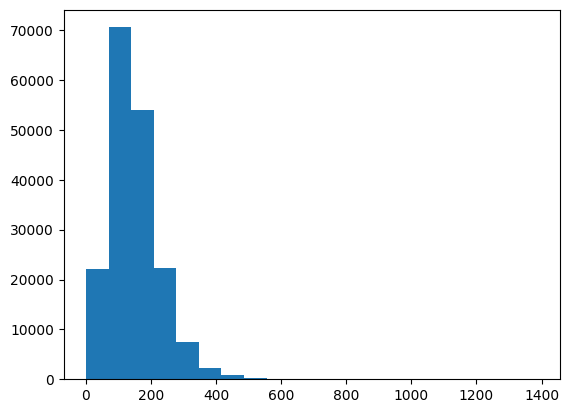

In [153]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [154]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [155]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [156]:
# Create char-level tokenizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and UNK
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                       output_sequence_length=output_seq_char_len,
                                       name="char_vectorizer")

In [157]:
# Adapt to training characters
char_vectorizer.adapt(train_chars)

In [158]:
# Check vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most frequent chars: {char_vocab[:5]}")
print(f"5 least frequent chars: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 Most frequent chars: ['', '[UNK]', 'e', 't', 'i']
5 least frequent chars: ['k', 'x', 'z', 'q', 'j']


In [159]:
# Test the character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of sentence: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Tokenized text:\n{vectorized_chars}")
print(f"Length of tokenized text: {len(vectorized_chars[0])}")

Charified text:
 a l s o   m e a s u r e d   w e r e   b a s e l i n e   c h a r a c t e r i s t i c s   ,   u s e   o f   a n d   a d h e r e n c e   t o   n i c o t i n e   r e p l a c e m e n t   t h e r a p y   a n d   p h a r m a c o t h e r a p y   ,   s m o k i n g   c h a r a c t e r i s t i c s   a n d   i m p l e m e n t a t i o n   o f   a   h o m e   s m o k i n g   b a n   .
Length of sentence: 161
Tokenized text:
[[ 5 12  9  7 15  2  5  9 16  8  2 10 20  2  8  2 22  5  9  2 12  4  6  2
  11 13  5  8  5 11  3  2  8  4  9  3  4 11  9 16  9  2  7 17  5  6 10  5
  10 13  2  8  2  6 11  2  3  7  6  4 11  7  3  4  6  2  8  2 14 12  5 11
   2 15  2  6  3  3 13  2  8  5 14 19  5  6 10 14 13  5  8 15  5 11  7  3
  13  2  8  5 14 19  9 15  7 23  4  6 18 11 13  5  8  5 11  3  2  8  4  9
   3  4 11  9  5  6 10  4 15 14 12  2 15  2  6  3  5  3  4  7  6  7 17  5
  13  7 15  2  9 15  7 23  4  6 18 22  5  6  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Create a character-level embedding

In [160]:
# Create char embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # the size of char embedding from table 1 in the paper
                              mask_zero=True,
                              name="char_embed")

In [161]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded text:\n{char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text:
a l s o   m e a s u r e d   w e r e   b a s e l i n e   c h a r a c t e r i s t i c s   ,   u s e   o f   a n d   a d h e r e n c e   t o   n i c o t i n e   r e p l a c e m e n t   t h e r a p y   a n d   p h a r m a c o t h e r a p y   ,   s m o k i n g   c h a r a c t e r i s t i c s   a n d   i m p l e m e n t a t i o n   o f   a   h o m e   s m o k i n g   b a n   .

Embedded text:
[[[-0.00238212  0.0166072   0.04473218 ...  0.02868488 -0.04910433
   -0.03866244]
  [-0.00838275 -0.03477304 -0.01318844 ... -0.01305058  0.00414149
   -0.04696161]
  [ 0.00946413 -0.02903482 -0.00486808 ...  0.01072949 -0.01825101
    0.02330257]
  ...
  [-0.02082727  0.01032537 -0.02969887 ... -0.00466446 -0.01766435
    0.03276658]
  [-0.02082727  0.01032537 -0.02969887 ... -0.00466446 -0.01766435
    0.03276658]
  [-0.02082727  0.01032537 -0.02969887 ... -0.00466446 -0.01766435
    0.03276658]]]

Char embedding shape: (1, 290, 25)


## Model 3: Conv1D with character embedding


In [162]:
# Make the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char")

# Compile
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [163]:
model_3.summary()

Model: "model_3_conv1d_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_5 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_average_pooling1d_5  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_9 (Dense)             (None, 5)         

In [ ]:
# Turn data into tensorflow datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices([train_chars, train_labels_one_hot]).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices([val_chars, val_labels_one_hot]).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices([test_chars, test_labels_one_hot]).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=5,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

In [ ]:
# Make predictions with characters only
model_3_pred_probs = model_3.predict(val_char_dataset)